# Исследование поведения пользователей мобильного приложения

_В этой работе необходимо исследовать поведение пользователей мобильного приложения в стартапе, который продает продукты питания. Требуется детально проанализировать воронку продаж и результаты A/A/B-эксперимента. В результате необходимо предоставить отчет о текущем положении дел._

Основные задачи которые необходимо решить в текущем исследовании:
 - [изучение данных и составление плана работ](#first_touch);
 - [предобработка данных (пропуски, дубликаты, типы данных)](#preprocessing);
 - [общий анализ данных](#general_analysis);
 - [анализ воронки событий](#funnel_analysis);
 - [анализ A/A/B-эксперимента](#test_analysis);
 - [вывод](#conclusion).

Описание данных: 
1. Датасет logs_exp (информация о действия пользователей):
 - EventName — название события;
 - DeviceIDHash **— уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Изучение данных и составление плана работ <a id="first_touch"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.io as pio
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
pio.renderers.default = 'svg'

In [3]:
logs_exp = pd.read_csv('/Users/dmitriichervakov/Desktop/praktikum/data/logs_exp.csv', sep='\t')

In [4]:
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


По результатам первого взгляда на данные можно сделать следующие выводы:
 - названия столбцов записаны не в самом удобном формате, их следует привести к более понятному и читабельному формату;
 - столбцы с названием события, идентификатором пользовтеля и идентификатором группы эксперимента записаны корректно и имеют соответствующий тип данных;
 - столбец с датой события записан в формате **unix time**. Его необходимо к понятному виду, а так же создать дополнительные столбцы с временем и датой;
 - во всех столбцах отсутствуют пропущенные значения;
 - необходимо проверить все данные на наличие дубликатов;
 - критических замечаний в датасете с первого взгляда не обнаружено. Если по ходу анализа найдутся дополнительные проблемы, я буду их решать на месте.

## Предобработка данных <a id="preprocessing"></a>

In [6]:
logs_exp.columns = ['event_name', 'device_id', 'event_time', 'test_id']

In [7]:
logs_exp['datetime'] = pd.to_datetime(logs_exp['event_time'], unit='s')

In [8]:
logs_exp['hour'] = logs_exp['datetime'].astype('datetime64[h]')

In [9]:
logs_exp.head()

,event_name,device_id,event_time,test_id,datetime,hour
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25 04:00:00
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25 11:00:00
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:00:00
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:00:00
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25 11:00:00


In [10]:
logs_exp.duplicated().sum()

413

In [11]:
logs_exp.duplicated().mean()

0.0016917493425526163

In [12]:
logs_exp.drop_duplicates(inplace=True)

В результате проверки на дубликаты было выявлено 413 полных копий строк исследуемого датасета, что составляет 0.17% от всего набора данных. Это допустимая потеря и я принял решение их удалить. Стоит обязательно сообщить в отдел разработки что при сборе данных появляются дубликаты. 

Немного поизучав характер дубликатов я не определил четкую причину их появления, однако могу описать некоторые особенности: 
 - самое большое относительное количество дубликатов связано с событием **Tutorial** - 3.2% от всех подобных событий являются дубликатами; 
 - как в экспериментальной так и в контрольных группах дубликаты распределились как и во всем объеме данных, перекоса в какую-либо из групп нет;
 - только 3 устройства оставили больше 10 копий своих действий, один из которых оставил 41 дубликат.

## Общий анализ данных <a id="general_analysis"></a>

**_Общее количество событий в логе_**

In [13]:
len(logs_exp)

243713

**_Общее количество пользователей в логе_**

In [14]:
logs_exp['device_id'].nunique()

7551

**_Среднее количество событий на пользователя_**

In [15]:
len(logs_exp) / logs_exp['device_id'].nunique()

32.27559263673685

**_Период исследуемых данных_**

In [16]:
logs_exp['datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [17]:
logs_exp['datetime'].max()

Timestamp('2019-08-07 21:15:17')

Минимальная и максимальная даты, на которые представлены данные в исследуемом датасете показывают что для анализа есть информация за 14 дней. Где 1ые и 14ые сутки неполные.

In [18]:
events = logs_exp.groupby('hour').agg({'event_name':'count'}).reset_index()

In [19]:
events.columns = ['hour', 'n_events']

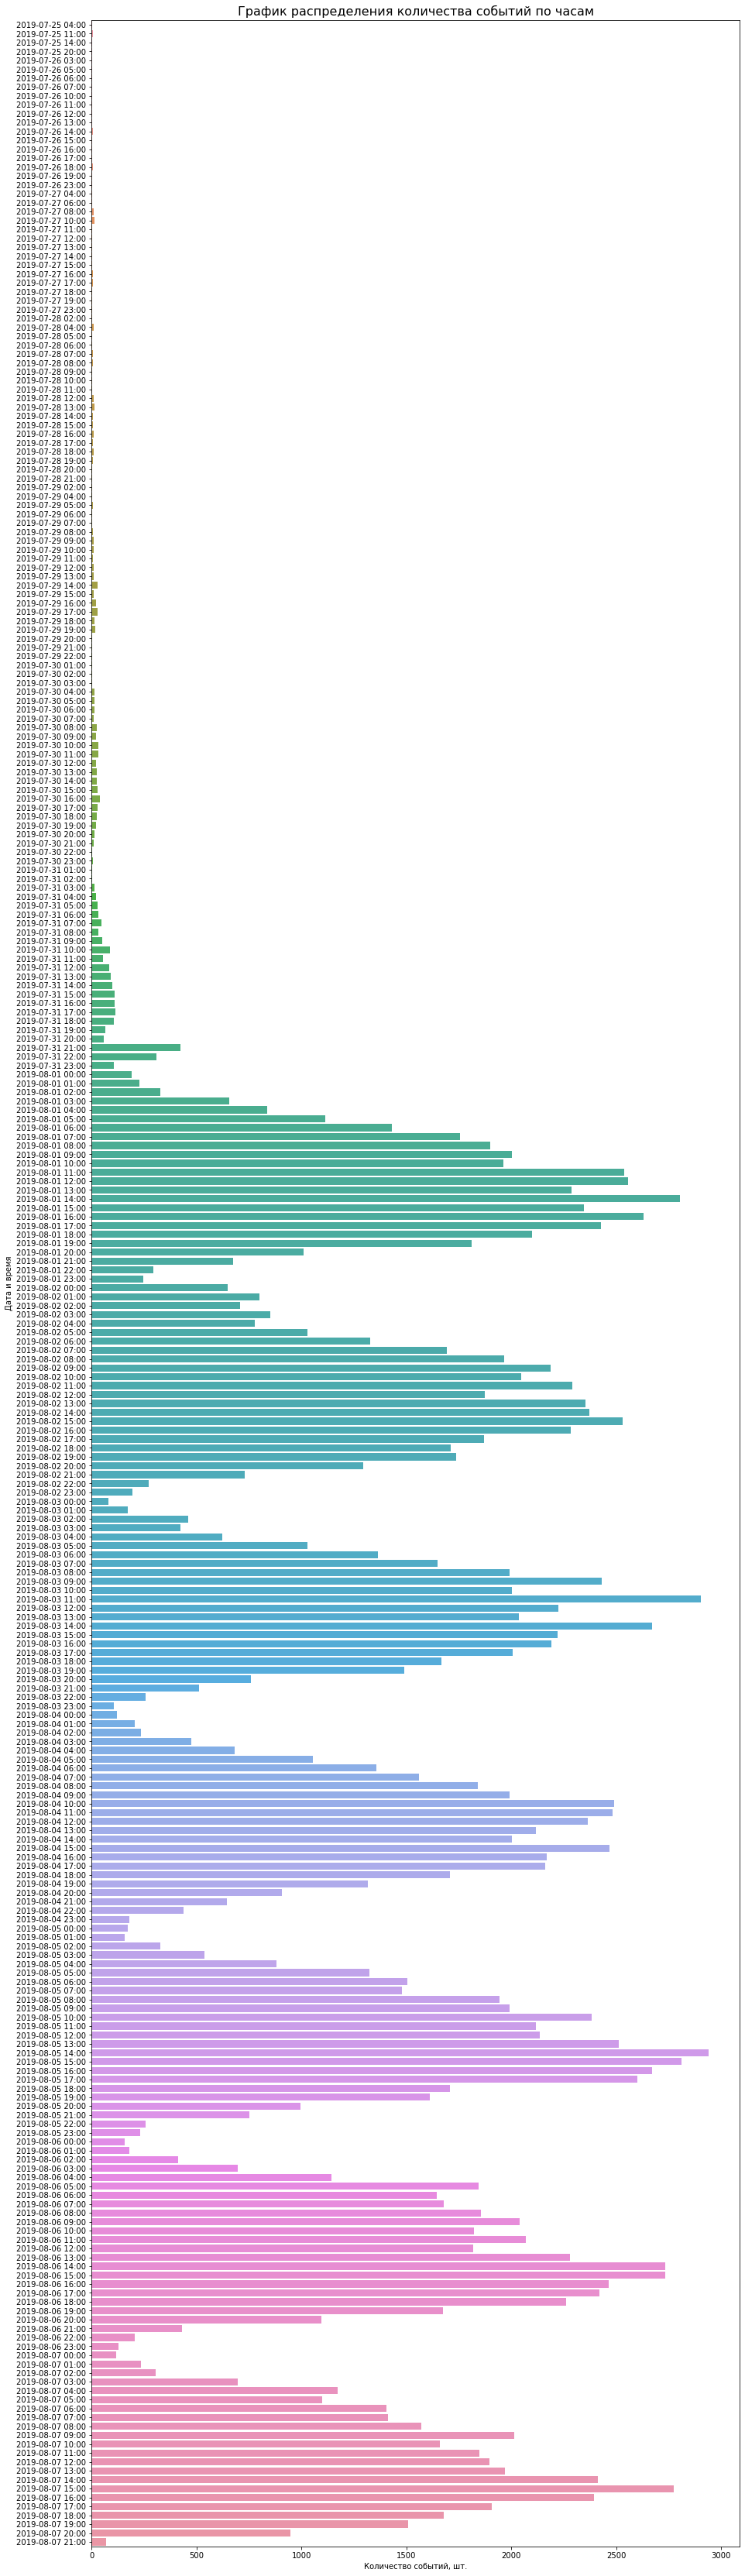

In [20]:
fig, ax = plt.subplots(figsize = (15,60))    

fig = sns.barplot(x='n_events', y='hour', data=events, estimator=sum, ci=None, ax=ax, orient='h')

y_dates = events['hour'].dt.strftime('%Y-%m-%d %H:%M')

ax.set_yticklabels(labels=y_dates)
ax.set_title('График распределения количества событий по часам', fontdict={'size':16})
ax.set_ylabel('Дата и время')
ax.set_xlabel('Количество событий, шт.')

plt.show()

График распределения количества событий, построенный по часам, показывает что реальная активность пользователей началась около 21.00 часа 31.07.2019. С этого момента предоставлены максимально полные данные. Далее в анализе я буду рассматривать данные начиная с этого времени. Всего вместо 14 остается 7 дней c достаточным количеством данных для анализа.

In [21]:
new_logs_exp = logs_exp.loc[logs_exp['hour'] >= '2019-07-31 21:00:00'].copy()

In [22]:
len(new_logs_exp) / len(logs_exp)

0.9918387611657975

In [23]:
new_logs_exp['device_id'].nunique() / logs_exp['device_id'].nunique()

0.9982783737253343

In [24]:
new_logs_exp.groupby('test_id').agg({'device_id':'count'})

,device_id
test_id,
246,79556
247,77293
248,84875


После удаления части данных за первые 7 дней осталось 99.1% всех событий и 99.8% всех пользователей. Так же в данных достаточно равномерно представлены события которые совершали пользователи из всех трех экспериментальных групп. Удаление незначительной части данных никак не повлияет на текущее исследование.

## Анализ воронки событий <a id="funnel_analysis"></a>

**_Типы событий в логе и частота их появлений_**

In [25]:
event_type = (new_logs_exp
              .groupby('event_name').agg({'device_id':'count'})
              .sort_values('device_id', ascending=False)
             )

In [26]:
event_type.columns = ['n_events']

In [27]:
event_type

,n_events
event_name,
MainScreenAppear,117889
OffersScreenAppear,46531
CartScreenAppear,42343
PaymentScreenSuccessful,33951
Tutorial,1010


**_Количество пользователей совершавших события_**

In [28]:
event_users = (new_logs_exp
               .groupby('event_name').agg({'device_id':'nunique'})
               .sort_values('device_id', ascending=False)
              )

In [29]:
event_users.columns = ['n_users']

In [30]:
event_users['%_users'] = event_users['n_users'] / new_logs_exp['device_id'].nunique()

In [31]:
event_users

,n_users,%_users
event_name,,
MainScreenAppear,7423,0.984744
OffersScreenAppear,4597,0.609843
CartScreenAppear,3736,0.495622
PaymentScreenSuccessful,3540,0.469621
Tutorial,843,0.111833


**_Последовательность воронки событий_**

На мой взгляд последовательность событий выстаривается в таком порядке:
0. Tutorial - экран-инструкция к приложению,
1. MainScreenAppear - главный экран приложения,
2. OffersScreenAppear - экран приложения с товарами,
3. CartScreenAppear - экран приложения с корзиной (с выбранными на прошлом экране товарами),
4. PaymentScreenSuccessful - экран подтверждения оплаты (появляется после оплаты товаров из предыдущего экрана).

Все события в рассматриваемом датасете складываются в последовательную цепочку действий.

**_Расчет конверсий воронки событий_**

In [32]:
event_users = event_users.query('index != "Tutorial"')

_При расчете конверсии воронки событий я не буду учитывать событие **Tutorial**, т.к. из-за наименьшего количества событий такого типа  оно попало в конец воронки и отображается как последний шаг цепочки событий, что в свою очередь может ввести в заблуждение людей изучающих отчет._

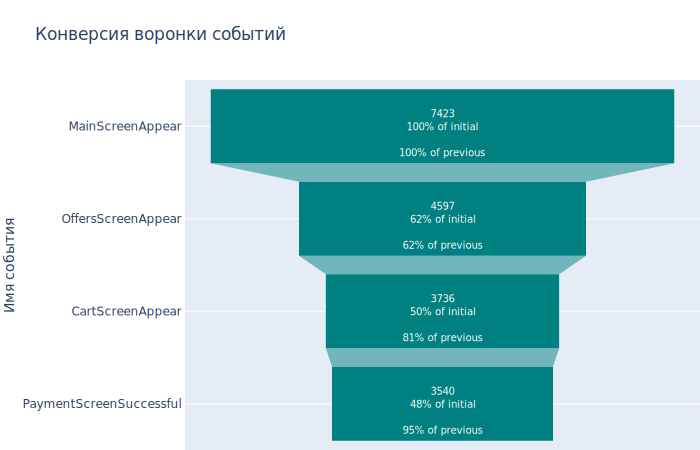

In [33]:
fig = go.Figure()

fig.add_trace(go.Funnel(x=event_users['n_users'], 
                        y=event_users.index, 
                        textinfo = 'value + percent initial + percent previous',
                        textfont = {"size": 10},
                        marker = {"color": "teal"}
                        ))

fig.update_layout(margin=dict(l=0, r=0, t=80, b=0),
                  title='Конверсия воронки событий', 
                  xaxis_title='Количество пользователей',
                  yaxis_title='Имя события')


fig.show()

По графику, изображенному выше, можно сделать следующие выводы:
 - больше всего пользователей теряется на 1 шаге - 38% человек не доходят до экрана приложения с товарами;
 - однако если пользователь попал на экран с товарами то вероятность того что он закончит сессию покупкой - очень высокая, 77% людей попавших на экран с товарами в итоге видят экран сигнализирующий об успешной оплате;
 - если рассматривать общую конверсию то 48% от всех пользователей открывших главный экран мобильного приложения стартапа доходят до покупки, почти каждый второй.

## Анализ A/A/B-эксперимента <a id="test_analysis"></a>

**_Подготовка данных для проверки статистической разницы попарно между всеми группами по каждому событию: 2 контрольными 246 и 247, 1ой контрольной и экспериментальной 246 и 248, 2ой контрольной и экспериментальной 247 и 248, объединенной контрольной и экспериментальной 250 и 248_**

In [34]:
users_in_test_groups = (new_logs_exp
                        .query('event_name != "Tutorial"')
                        .groupby(['event_name','test_id']).agg({'device_id':'nunique'})
                        .sort_values('device_id', ascending=False)
                        .reset_index()
                       )

In [35]:
# n_users_compl_event = number of users who completed the event 
# (количество уникальных пользователей в каждой экспериментальной группе которые совершили событие)

users_in_test_groups.columns = ['event_name', 'test_id', 'n_users_compl_event']

In [36]:
test_nunique = new_logs_exp.groupby('test_id').agg({'device_id':'nunique'}).reset_index()

In [37]:
# общее количество уникальных пользователей в каждой экспериментальной группе

test_nunique.columns = ['test_id', 'n_users_total']

In [38]:
users_in_test_groups = (users_in_test_groups
                        .merge(test_nunique, 
                               left_on='test_id', 
                               right_on='test_id', 
                               how='left')
                       )

_Добавление строк с данными по объединенной контрольной группе **246+247** для каждого события. Объединенная группа будет анализироваться под номером **250**_

In [39]:
users_in_test_groups.loc[12] = ('MainScreenAppear', 
                                250, 
                                (users_in_test_groups.loc[2, 'n_users_compl_event'] +
                                users_in_test_groups.loc[1, 'n_users_compl_event']),
                                (users_in_test_groups.loc[2, 'n_users_total'] +
                                users_in_test_groups.loc[1, 'n_users_total'])
                               )

In [40]:
users_in_test_groups.loc[13] = ('OffersScreenAppear', 
                                250, 
                                (users_in_test_groups.loc[3, 'n_users_compl_event'] +
                                users_in_test_groups.loc[5, 'n_users_compl_event']),
                                (users_in_test_groups.loc[3, 'n_users_total'] +
                                users_in_test_groups.loc[5, 'n_users_total'])
                               )

In [41]:
users_in_test_groups.loc[14] = ('CartScreenAppear', 
                                250, 
                                (users_in_test_groups.loc[6, 'n_users_compl_event'] +
                                users_in_test_groups.loc[7, 'n_users_compl_event']),
                                (users_in_test_groups.loc[6, 'n_users_total'] +
                                users_in_test_groups.loc[7, 'n_users_total'])
                               )

In [42]:
users_in_test_groups.loc[15] = ('PaymentScreenSuccessful', 
                                250, 
                                (users_in_test_groups.loc[9, 'n_users_compl_event'] +
                                users_in_test_groups.loc[11, 'n_users_compl_event']),
                                (users_in_test_groups.loc[9, 'n_users_total'] +
                                users_in_test_groups.loc[11, 'n_users_total'])
                               )

In [43]:
users_in_test_groups.set_index(['event_name','test_id'], inplace=True)

In [44]:
# доля пользователей совершивших событие в каждой экспериментальной группе

users_in_test_groups['%_users_compl_event'] = (users_in_test_groups['n_users_compl_event'] / 
                                               users_in_test_groups['n_users_total']
                                              )

In [45]:
users_in_test_groups

n_users_compl_event  n_users_total  \
event_name              test_id                                       
MainScreenAppear        248                     2494           2537   
                        247                     2479           2517   
                        246                     2450           2484   
OffersScreenAppear      246                     1542           2484   
                        248                     1531           2537   
                        247                     1524           2517   
CartScreenAppear        246                     1266           2484   
                        247                     1239           2517   
                        248                     1231           2537   
PaymentScreenSuccessful 246                     1200           2484   
                        248                     1182           2537   
                        247                     1158           2517   
MainScreenAppear        250                     4929           5001   
OffersScreenAppear      250                     3066           5001   
CartScreenAppear        250                     2505           5001   
PaymentScreenSuccessful 250                     2358           5001   

                                 %_users_compl_event  
event_name              test_id                       
MainScreenAppear        248                 0.983051  
                        247                 0.984903  
                        246                 0.986312  
OffersScreenAppear      246                 0.620773  
                        248                 0.603469  
                        247                 0.605483  
CartScreenAppear        246                 0.509662  
                        247                 0.492253  
                        248                 0.485219  
PaymentScreenSuccessful 246                 0.483092  
                        248                 0.465905  
                        247                 0.460072  
MainScreenAppear        250                 0.985603  
OffersScreenAppear      250                 0.613077  
CartScreenAppear        250                 0.500900  
PaymentScreenSuccessful 250                 0.471506

In [46]:
# функция проверки статистически значимой разницы между долями групп

# успехом считается число пользователей совершивших событие в каждой экспериментальной группе
# попыткой считается общее число пользователей в каждой экспериментальной группе

def equality_z_test(successes_group_1, trials_group_1, successes_group_2, trials_group_2):
    alpha = .01
    p1 = successes_group_1 / trials_group_1
    p2 = successes_group_2 / trials_group_2
    p_combined = (successes_group_1 + successes_group_2) / (trials_group_1 + trials_group_2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_group_1 + 1/trials_group_2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

**_Проверка статистической значимой разницы между контрольными группами 246 и 247 по каждому событию (A/A-тест)_**

**Постановка гипотез:**

Нулевая гипотеза: отношения количества пользователей совершивших событие к количеству пользователей в каждой контрольной группе одинковое, между долями нет разницы. Набюдаемые различия случайны.

Альтернативная гипотеза: между отношениями количества пользователей совершивших событие к количеству пользователей в каждой контрольной группе есть значимая разница.

alpha = 0.01 (1%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

_Событие MainScreenAppear_

In [47]:
equality_z_test(users_in_test_groups.loc[('MainScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('MainScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 247)]['n_users_total'])

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие OffersScreenAppear_

In [48]:
equality_z_test(users_in_test_groups.loc[('OffersScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('OffersScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 247)]['n_users_total'])

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие CartScreenAppear_

In [49]:
equality_z_test(users_in_test_groups.loc[('CartScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('CartScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 247)]['n_users_total'])

p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие PaymentScreenSuccessful_

In [50]:
equality_z_test(users_in_test_groups.loc[('PaymentScreenSuccessful', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 246)]['n_users_total'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 247)]['n_users_total'])

p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты 4 A/A-экспериментов для контрольных групп по каждому событию показали во всех случаях значения p-value больше статически значимой величины. Это означает что нет оснований полагать что существует статистически значимое различие между контрольными группами, а так же подтверждает тот факт что разбиние на группы сработало корректно. 

**_Проверка статистической значимой разницы между 1ой контрольной и экспериментальной группами 246 и 248 по каждому событию (A/B-тест)_**

**Постановка гипотез:**

Нулевая гипотеза: отношения количества пользователей совершивших событие к количеству пользователей в 1ой контрольной и экспериментальной группах одинковое, между долями нет разницы. Набюдаемые различия случайны.

Альтернативная гипотеза: между отношениями количества пользователей совершивших событие к количеству пользователей в 1ой контрольной и экспериментальной группах есть значимая разница.

alpha = 0.01 (1%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

_Событие MainScreenAppear_

In [51]:
equality_z_test(users_in_test_groups.loc[('MainScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_total'])

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие OffersScreenAppear_

In [52]:
equality_z_test(users_in_test_groups.loc[('OffersScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_total'])

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие CartScreenAppear_

In [53]:
equality_z_test(users_in_test_groups.loc[('CartScreenAppear', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 246)]['n_users_total'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_total'])

p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие PaymentScreenSuccessful_

In [54]:
equality_z_test(users_in_test_groups.loc[('PaymentScreenSuccessful', 246)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 246)]['n_users_total'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_total'])

p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты 4 A/B-экспериментов для 1ой контрольной и экспериментальной групп по каждому событию показали во всех случаях значения p-value больше статически значимой величины. Это означает что нет оснований полагать что существует статистически значимое различие между исследуемыми группами.

**_Проверка статистической значимой разницы между 2ой контрольной и экспериментальной группами 247 и 248 по каждому событию (A/B-тест)_**

**Постановка гипотез:**

Нулевая гипотеза: отношения количества пользователей совершивших событие к количеству пользователей в 2ой контрольной и экспериментальной группах одинковое, между долями нет разницы. Набюдаемые различия случайны.

Альтернативная гипотеза: между отношениями количества пользователей совершивших событие к количеству пользователей в 2ой контрольной и экспериментальной группах есть значимая разница.

alpha = 0.01 (1%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

_Событие MainScreenAppear_

In [55]:
equality_z_test(users_in_test_groups.loc[('MainScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 247)]['n_users_total'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_total'])

p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие OffersScreenAppear_

In [56]:
equality_z_test(users_in_test_groups.loc[('OffersScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 247)]['n_users_total'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_total'])

p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие CartScreenAppear_

In [57]:
equality_z_test(users_in_test_groups.loc[('CartScreenAppear', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 247)]['n_users_total'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_total'])

p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие PaymentScreenSuccessful_

In [58]:
equality_z_test(users_in_test_groups.loc[('PaymentScreenSuccessful', 247)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 247)]['n_users_total'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_total'])

p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты 4 A/B-экспериментов для 2ой контрольной и экспериментальной групп по каждому событию показали во всех случаях значения p-value больше статически значимой величины. Это означает что нет оснований полагать что существует статистически значимое различие между исследуемыми группами.

**_Проверка статистической значимой разницы между объединенной контрольной и экспериментальной группами 250 и 248 по каждому событию (A/B-тест)_**

**Постановка гипотез:**

Нулевая гипотеза: отношения количества пользователей совершивших событие к количеству пользователей в объединенной контрольной и экспериментальной группах одинковое, между долями нет разницы. Набюдаемые различия случайны.

Альтернативная гипотеза: между отношениями количества пользователей совершивших событие к количеству пользователей в объединенной контрольной и экспериментальной группах есть значимая разница.

alpha = 0.01 (1%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

_Событие MainScreenAppear_

In [59]:
equality_z_test(users_in_test_groups.loc[('MainScreenAppear', 250)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 250)]['n_users_total'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('MainScreenAppear', 248)]['n_users_total'])

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие OffersScreenAppear_

In [60]:
equality_z_test(users_in_test_groups.loc[('OffersScreenAppear', 250)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 250)]['n_users_total'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('OffersScreenAppear', 248)]['n_users_total'])

p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие CartScreenAppear_

In [61]:
equality_z_test(users_in_test_groups.loc[('CartScreenAppear', 250)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 250)]['n_users_total'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('CartScreenAppear', 248)]['n_users_total'])

p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Событие PaymentScreenSuccessful_

In [62]:
equality_z_test(users_in_test_groups.loc[('PaymentScreenSuccessful', 250)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 250)]['n_users_total'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_compl_event'], 
                users_in_test_groups.loc[('PaymentScreenSuccessful', 248)]['n_users_total'])

p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты 4 A/B-экспериментов для объединенной контрольной и экспериментальной групп по каждому событию показали во всех случаях значения p-value больше статически значимой величины. Это означает что нет оснований полагать что существует статистически значимое различие между исследуемыми группами.

## Вывод <a id="conclusion"></a>

После открытия и первого ознакомления с данными стало ясно что период исследуемых даных - 14 дней или 2 недели. Но после детального анализа распределения количества событий в день проявился тот факт что за первые 7 дней предоставленно пренебрежимо мало данных, которые нельзя использовать для анализа и делать какие-либо значительные выводы. Наоборот оставлять эти "остаточные" данные первых 7 дней с "полными" данными за последнюю неделю  было бы некорректно, что в своб очередь могло привести к искажению объективной картины. Весь анализ в работе был проведен на данных период которых составил 7 суток. 

Подробно изучив воронку событий я сделал следующие выводы:
- самое большое падение конверсии приходится на первый шаг: гравный экран - экран с товарами. 38% пользователей мобильного приложения не доходят до экрана с выбором товаров. Причин у этого явления может быть очень много, например от несамого интуитивного интерфейса и сложности/невозможности прохождения "туториала" до медленной или нестабильной работы приложения;
- однако, после прохождения 62% пользователей на экран с выбором товаров, далее конверсия падает с гораздо меньшим темпом и до экрана с корзиной доходят ровно половина - 50% от всех пользователей приложения. Снижение темпа падения конверсии шага 2 к шагу 1 - почти в 2 раза;
- удивительной для меня стала последняя коверсия, 95% пользователей увидевших экран с корзиной в итоге оплачивали свои покупки. Или если считать в обещй массе пользователей - 48%, почти каждый второй зашедший в приложение доходил до экрана, сигнализирующего об успешной оплате товаров. 

В результате анализа A/A/B - эксперимента можно с уверенностью сказать что разницы в пользовательском поведения во всех 3 группах не наблюдается. Для большей точности эксперимент был проведен с двумя контрольными группами и одной экспериментальной. В ходе эксперимента были проведены 16 попарных тестов между всеми группами. Все они показали единый результат - отсутствие статистически значимой разницы между количеством пельзователей в каждой из групп. Это значит что пользователи сохраняют свою активность и при изменении шрифтов в приложении, это их не пугает и не создает непонятного ощущения. В данной ситуации если дизайнеры сочли лучшим вариантом поменять старые шрифты на новые, нет никаких оснований полагать что пользователем станет неудобно пользоваться приложением. Менеджеры могут быть спокойны и не волноваться:)